In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import pymc as pm
import arviz as az
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
!pip install pingouin
import pingouin as pg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 15.3 MB/s eta 0:00:00


#Adjusted R2'ye göre En İyi Regresyon Modelini Bulmak

In [ ]:
df = sm.datasets.get_rdataset(dataname='mtcars', package='datasets').data
df.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
rownames,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [ ]:
y = df['mpg']
X = df.drop('mpg', axis=1)

X = sm.add_constant(X)

baseline_model = sm.OLS(y, X).fit()
print(f"Başlangıç modelinin düzeltilmiş R² değeri: {baseline_model.rsquared_adj}")

best_r2_adj = baseline_model.rsquared_adj
best_model = baseline_model

# Her bir değişken için modeli test et
for i in range(1, len(X.columns)):
    temp_X = X.iloc[:, :i+1]  # İlk i değişkeni seç
    temp_model = sm.OLS(y, temp_X).fit()

    # Düzeltilmiş R² değerini kontrol et
    if temp_model.rsquared_adj > best_r2_adj:
        print(f"Eklenen değişkenler: {temp_X.columns.tolist()}")
        print(f"Düzeltilmiş R²: {temp_model.rsquared_adj}\n")
        best_r2_adj = temp_model.rsquared_adj
        best_model = temp_model

# En iyi modelin özetini yazdır
print(best_model.summary())

Başlangıç modelinin düzeltilmiş R² değeri: 0.806642318990986
Eklenen değişkenler: ['const', 'cyl', 'disp', 'hp', 'drat', 'wt']
Düzeltilmiş R²: 0.8227219455006664

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     29.77
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           5.62e-10
Time:                        11:08:19   Log-Likelihood:                -71.883
No. Observations:                  32   AIC:                             155.8
Df Residuals:                      26   BIC:                             164.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

# Tek Popülasyon Üzerinden Proporsiyon Çıkarımları

## P-Değeri nedir? Proporsiyon Analizi

In [ ]:
observed = 5*[1] + 45*[0]
observed = np.array(observed)

simulation_results = stats.bootstrap((observed,),statistic = np.mean,)

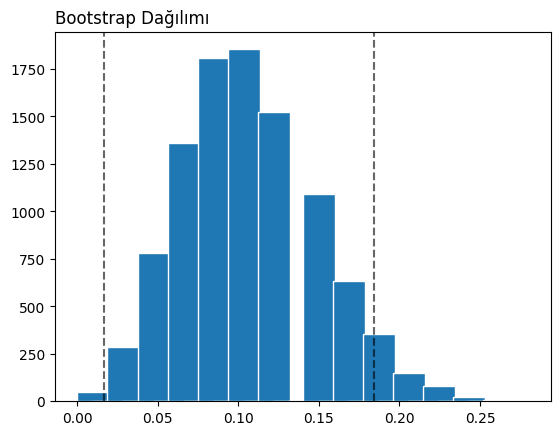

In [ ]:
plt.figure()
plt.hist(simulation_results.bootstrap_distribution, bins=30, edgecolor = "white",width = 0.02)
plt.axvline(np.mean(simulation_results.bootstrap_distribution) - 1.96 * np.std(simulation_results.bootstrap_distribution), alpha = 0.6, color = 'black', linestyle = "--")
plt.axvline(np.mean(simulation_results.bootstrap_distribution) + 1.96 * np.std(simulation_results.bootstrap_distribution), alpha = 0.6, color = 'black', linestyle = "--")
plt.title("Bootstrap Dağılımı", loc = "left")
plt.show()

* Dikey çizgilerin dışında kalan örnek sayısı / simülasyon sayısı `p-değeri` ni verir.

* 95% eminiz ki gerçek aralık iki dikey çizginin arasında yer alır.

**Q:** 62 kişiden oluşan bir grupta 5 tedavi olduğunu gördük. Gerçek tedavi oranının 10% olma ihtimali nedir?



In [ ]:
n = 62
p_null = 0.1
observed = 5
observed_probability = observed/n

simulation_results = np.random.binomial(n, p_null, 10000) #62 kişiden 0.1 ihtimalle pozitif yarat. 10000 defa tekrarla. pozitifleri topla
simulation_results[0:5]

array([5, 5, 4, 9, 5])

In [ ]:
simulation_proportions = simulation_results / n
p_value = np.mean(simulation_proportions <= observed_probability) #kaç tanesi null hipotezinden az içeriyor.
p_value

0.4059

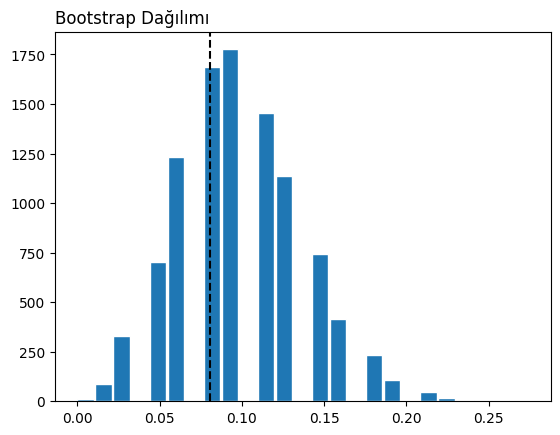

In [ ]:
plt.figure()
plt.hist(simulation_proportions,edgecolor = "white",bins = 25,width = 0.010)
plt.axvline(observed_probability, color = 'black', linestyle = "--")
plt.title("Bootstrap Dağılımı", loc = "left")
plt.show()

Alternatif olarak `stats.binomtest` kullanabiliriz.

In [ ]:
stats.binomtest(tedavi, tedavi+kalan, 0.1, alternative = "less")

BinomTestResult(k=5, n=62, alternative='less', statistic=0.08064516129032258, pvalue=0.4042508274538528)

## Proporsiyon Analizi için Normal Varsayımı

Proporsiyon tahmincileri, başarı (1) ve başarısız (0) sayısı 10 ya da fazla olduğunda normal dağılım sergilerler. Bu durumda standart hataları

$SE = \sqrt{\frac{{\hat{p} \times (1 - \hat{p})}}{n}}$

$\hat{p}:$ Tahmincilerin ortalaması (best estimator)

ile hesaplanır. Hata payı (Margin of Error) ise

$ME = z \times \sqrt{\frac{{\hat{p} \times (1 - \hat{p})}}{n}}$

ile bulunur. Burada $z$ ilgilenilen persentile karşılık gelir. (95% CI: z = 1.96)

Biraz önceki deneyde observed statistic 62/10 = 6.2 olduğundan uyguladığımız prosedür geçerli değildi.



Q: n = 826; p = 0.7. ME? CI?

In [ ]:
simulations = np.random.binomial(826,0.7,10000)
simulation_proportions = simulations / 826
simulation_proportions[0:5]

array([0.70460048, 0.69007264, 0.69612591, 0.70338983, 0.70338983])

In [ ]:
stdev = np.std(simulation_proportions)
ci = (np.mean(simulation_proportions) - 1.96 * stdev, np.mean(simulation_proportions) + 1.96 * stdev)
np.round(ci,3)

array([0.669, 0.732])

# İki Popülasyon Üzerinden Proporsiyon Çıkarımları

## Proporsiyon Analizi

İki popülasyonun oran tahmincileri $\hat{p}_1$ ve $\hat{p}_2$ olmak üzere,

İki proporsiyon arasındaki fark, bu popülasyonlara ait başarı (1) ve başarısızlık (0) sayısı en az 10 ise normal dağılım sergiler. (Normal Varsayımı)

In [ ]:
cpr = pd.read_csv('/content/drive/MyDrive/Stats Data/cpr.csv')
cpr.head()

,group,outcome
0,control,survived
1,control,survived
2,control,survived
3,control,survived
4,control,survived


In [ ]:
control = cpr[cpr["group"] == "control"].outcome.replace({"died": 0,"survived": 1}).values
treatment = cpr[cpr["group"] == "treatment"].outcome.replace({"died": 0,"survived": 1}).values

<ipython-input-17-ae78833dc4c7>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  control = cpr[cpr["group"] == "control"].outcome.replace({"died": 0,"survived": 1}).values
<ipython-input-17-ae78833dc4c7>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  treatment = cpr[cpr["group"] == "treatment"].outcome.replace({"died": 0,"survived": 1}).values


## Standard Hata Aralıkları ile Hipotez Testi Sonuçlarının Değerlendirilmesi

In [ ]:
control_samples = stats.bootstrap((control,), np.mean, random_state=42, n_resamples=10000)
treatment_samples = stats.bootstrap((treatment,), np.mean, random_state=42, n_resamples=10000)

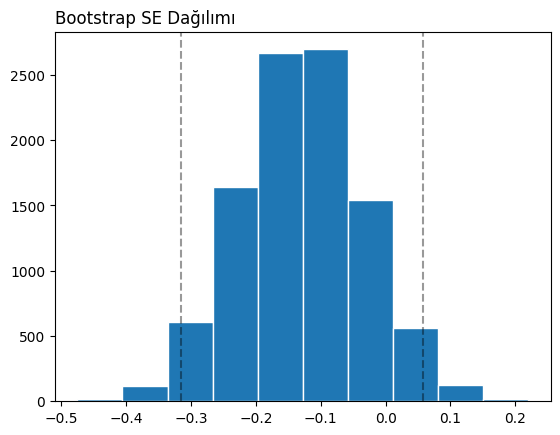

In [ ]:
difference = control_samples.bootstrap_distribution - treatment_samples.bootstrap_distribution
std_err = np.std(difference)
first_limit = difference.mean() - 1.96 * std_err
second_limit = difference.mean() + 1.96 * std_err

plt.figure()
plt.hist(difference, bins=10, edgecolor = "white")
plt.axvline(first_limit, color='black', linestyle = "--", alpha = 0.4)
plt.axvline(second_limit, color='black', linestyle = "--", alpha = 0.4)
plt.title("Bootstrap SE Dağılımı", loc = "left")
plt.show()

İki grup arasında belirgin bir fark yoktur.

## Binom Testi

Veri sayısı az olduğunda, nomral varsayımı karşılanmadığında success-failure grubunun şanstan ortaya çıkma ihtimalini ölçmek için kullanılır.

* $H_0: p = 0.5$
* $H_A: p \neq 0.5$

In [ ]:
np.unique(treatment,return_counts = True)

(array([0, 1]), array([26, 14]))

In [ ]:
np.unique(control,return_counts = True)

(array([0, 1]), array([39, 11]))

In [ ]:
stats.binomtest(14,40,p = 0.5)

BinomTestResult(k=14, n=40, alternative='two-sided', statistic=0.35, pvalue=0.0806904677519924)

H0'ı reddedecek kadar verimiz yok.

## Two Proportion Z-test

Bağımsız iki çıktılı grupları karşılaştırmak için kullanılır.

* Normal varsayımı karşılanmak zorundadır. (Tanım için önceki kısım)

* T-testi devamlı verilerin ortalamalarının karşılaştılması için kullanılır. Success failure durumları kategorik çıktılardır. Bu yüzden kullanamayız.

* Sade binom testini kullanmak ise tedavi grubunun verilen olasılıkta oluşma ihtimalini ölçer. Kontrol grubuyla bir kıyaslama yapmaz.

>The z-test is a statistical test for comparing the proportions from two populations. It can be used when the samples are independent,  n1p^1
  ≥ 10,  n1q^1
  ≥ 10,  n2p^2
  ≥ 10, and  n2q^2
  ≥ 10. ([Link](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Mostly_Harmless_Statistics_(Webb)/09%3A_Hypothesis_Tests_and_Confidence_Intervals_for_Two_Populations/9.03%3A_Two_Proportion_Z-Test_and_Confidence_Interval))

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

count = [14, 11]
nobs = [40, 50]

stat, pval = proportions_ztest(count, nobs, alternative='two-sided')
print(f"Test Statistic: {stat:.4f}, p-value: {pval:.4f}")

Test Statistic: 1.3682, p-value: 0.1712


H0'ı reddecek yeterli verimiz yok.

## Bootstrap P-Values (Permutation Test)

**Varsayımlar:**
* Örnekler birbirlerinden bağımsız olmalıdırlar.

In [ ]:
observed_statistic = np.mean(treatment) - np.mean(control)
combined_observations = np.concatenate((treatment, control))
number_of_simulations = 10000
p_count = 0

for _ in range(number_of_simulations):
  np.random.shuffle(combined_observations)
  resampled_treatment = combined_observations[:len(treatment)]
  resampled_control = combined_observations[len(treatment):]

  resampled_statistic = np.mean(resampled_treatment) - np.mean(resampled_control)
  if resampled_statistic >= observed_statistic:
      p_count += 1

p_value = p_count / number_of_simulations
print(f"p-value: {p_value:.4f}")

p-value: 0.1321


İki grup arasında belirgin bir fark yoktur.

In [ ]:
#alternatif olarak
from scipy.stats import permutation_test

observed_statistic = np.mean(treatment) - np.mean(control)
result = permutation_test((treatment, control), statistic=lambda x, y: np.mean(x) - np.mean(y),
                          permutation_type='independent', alternative='greater', n_resamples=10000)

print(f"p-value: {result.pvalue:.4f}")

p-value: 0.1298


# SORULAR

## 2.SORU

**Q:** n1 = 4373, k1 = 223; n2 = 4736, k2 = 279

İki oran birbirlerinden farklı mı?

* H0: $\hat{p}_1 - \hat{p}_2 = 0$
* H1: $\hat{p}_1 - \hat{p}_2 \neq 0$

Z-testi `nan` döndürüyor. Çünkü oranlar çok düşük.

In [ ]:
stat,pval = proportions_ztest(count = [4373,4736], nobs = [223,279], alternative = "two-sided")
stat,pval

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/proportion.py:1024: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


(nan, nan)

In [ ]:
group1 = np.repeat([0,1], [4373 - 223,223])
group2 = np.repeat([0,1], [4736 - 279,279])
group1_samples = stats.bootstrap((group1,),statistic = np.mean)
group2_samples = stats.bootstrap((group2,),statistic = np.mean)

difference_distribution = group1_samples.bootstrap_distribution - group2_samples.bootstrap_distribution
confidence_interval = (np.mean(difference_distribution) - 1.96 * np.std(difference_distribution), np.mean(difference_distribution) + 1.96 * np.std(difference_distribution))
confidence_interval

(-0.017390600836867512, 0.001507567347765729)

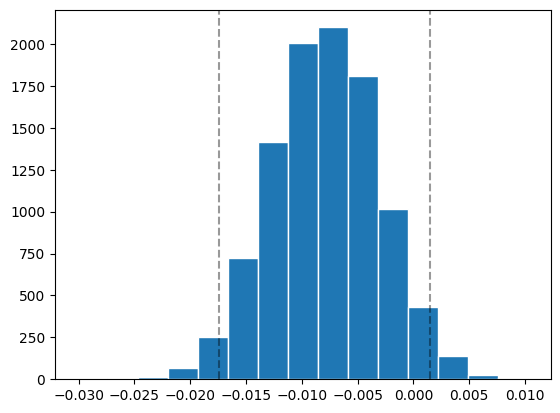

In [ ]:
plt.figure()
plt.hist(difference_distribution, bins=15, edgecolor = "white")
plt.axvline(confidence_interval[0], color='black', linestyle = "--", alpha = 0.4)
plt.axvline(confidence_interval[1], color='black', linestyle = "--", alpha = 0.4)
plt.show()

**Sezgisel anlam:** Eğer gözlemlenen istatistikten mutlak anlamda daha yüksek bir istatistik elde etme oranımız tüm simülasyonların 5%'si veya daha azıysa ortaya çıkan gözlem muhtemelen şans eseri değildir.

## 3.SORU

**Q:** Treatment results:
* 26: 1; 94:0
* 10: 1; 110:0

* $H_0: p_1 = p_2$
* $H_A: p_1 \neq p_2$


In [ ]:
group1 = np.repeat([0,1], [26,94])
group2 = np.repeat([0,1], [10,110])

group1_samples = stats.bootstrap((group1,),statistic = np.mean)
group2_samples = stats.bootstrap((group2,),statistic = np.mean)

difference_distribution = group1_samples.bootstrap_distribution - group2_samples.bootstrap_distribution
confidence_interval = (np.mean(difference_distribution) - 1.96 * np.std(difference_distribution), np.mean(difference_distribution) + 1.96 * np.std(difference_distribution))
confidence_interval


(-0.22210057076789746, -0.04453942656516918)

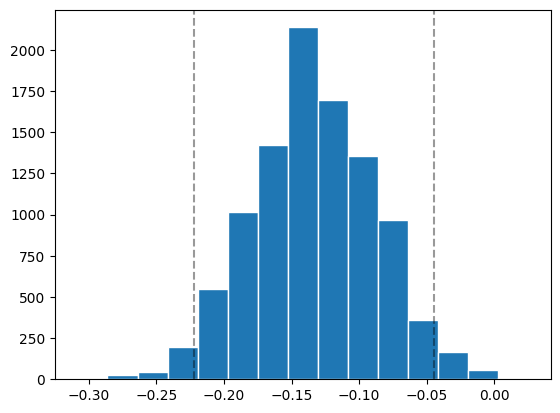

In [ ]:
plt.figure()
plt.hist(difference_distribution,edgecolor = "white", bins = 15)
plt.axvline(confidence_interval[0], color='black', linestyle = "--", alpha = 0.4)
plt.axvline(confidence_interval[1], color='black', linestyle = "--", alpha = 0.4)
plt.show()

In [ ]:
test_stat,p_val = statsmodels.stats.proportion.proportions_ztest(nobs = [120,120], count = [26,10], alternative = "two-sided")
p_val

0.0038230343585820776

In [ ]:
stats.permutation_test(data = (group1,group2),statistic = lambda x,y: np.mean(x) - np.mean(y))

PermutationTestResult(statistic=-0.1333333333333333, pvalue=0.0066, null_distribution=array([ 0.06666667, -0.01666667, -0.06666667, ...,  0.        ,
        0.06666667, -0.01666667]))

## 4.SORU

* Demokratlar: n = 347; 79% support
* Bağımsızlar: n = 617; 55% support

* $H_0: p_1 - p_2 = 0$
* $H_A: p_1 - p_2 \neq 0$

In [ ]:
support_democrats = np.round(347 * 0.79)
support_independent = np.round(617 * 0.55)

test_stat,p_val = statsmodels.stats.proportion.proportions_ztest(count = [support_democrats,support_independent],
                                              nobs = [347,617])
p_val

1.0135640612340426e-13

# Ki-Kare Testi

İki veya daha fazla kategorik değişkenin sayımlarına bakarak, değişkenler arasında bir ilişki olup olmadığını belirler. İlişkinin yönü hakkında bir fikir vermez.

**Gereksinimler**

* Veriler ordinal (sıralı kategorik) veya nominal (sırasız kategorik) olmalıdır.
* Her veri noktası tek bir sınıfta yer almalıdır.
* Her hücrede en az 5 veri noktası olmalıdır.
* Normal dağılım varsayımı **yoktur.**
---
* $H_0:$ Kategorik değişkenler arasında bir ilişki yoktur.
* $H_A:$ Kategorik değişkenler arasında bir ilişki vardır.


In [ ]:
table = np.array([[29,44],
                  [15,58],
                  [17,56]])

test_stat,p_val,dof,expected = stats.chi2_contingency(table)
test_stat,p_val

(7.816559452168501, 0.020075005883281965)

In [ ]:
data = {
    'Cinsiyet': ['Kadın', 'Erkek', 'Kadın', 'Erkek', 'Kadın', 'Erkek', 'Kadın', 'Erkek'],
    'Sigara_Icme_Durumu': ['İçiyor', 'İçmiyor', 'İçiyor', 'İçmiyor', 'İçmiyor', 'İçiyor', 'İçiyor', 'İçmiyor']
}

df = pd.DataFrame(data)
df.head()

,Cinsiyet,Sigara_Icme_Durumu
0,Kadın,İçiyor
1,Erkek,İçmiyor
2,Kadın,İçiyor
3,Erkek,İçmiyor
4,Kadın,İçmiyor


In [ ]:
contingency_table = pd.crosstab(df['Cinsiyet'], df['Sigara_Icme_Durumu'])
contingency_table

Sigara_Icme_Durumu,İçiyor,İçmiyor
Cinsiyet,,
Erkek,1,3
Kadın,3,1


In [ ]:
#normalize etmek için
contingency_table = pd.crosstab(df['Cinsiyet'], df['Sigara_Icme_Durumu'], normalize = "index")
contingency_table

Sigara_Icme_Durumu,İçiyor,İçmiyor
Cinsiyet,,
Erkek,0.25,0.75
Kadın,0.75,0.25


In [ ]:
#toplamları göstermek
contingency_table = pd.crosstab(df['Cinsiyet'], df['Sigara_Icme_Durumu'], margins = True)
contingency_table


Sigara_Icme_Durumu,İçiyor,İçmiyor,All
Cinsiyet,,,
Erkek,1,3,4
Kadın,3,1,4
All,4,4,8


# İki Popülasyon Üzerinden Ortalamala Çıkarımları

**Permütasyon Testi Varsayımları:**

* Örnekler birbirlerinden bağımsızlardır.



In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/classdata.csv")
df.head()

,m1,lecture
0,67,a
1,59,a
2,100,a
3,81,a
4,80,a


# SORULAR

In [ ]:
a = df[df.lecture == "a"].m1.values
b = df[df.lecture == "b"].m1.values

In [ ]:
observed_difference = np.mean(a) - np.mean(b)
observed_difference

3.139811912225696

* $H_0: \mu_1 - \mu_2 = 0$
* $H_A: \mu_1 - \mu_2 \neq 0$


In [ ]:
combined_data = np.concatenate((a,b))
p_counts = 0
resampled_difference = []
for _ in range(10000):
  np.random.shuffle(combined_data)
  resampled_a = combined_data[:len(a)]
  resampled_b = combined_data[len(a):]
  resampled_difference.append(np.mean(resampled_a) - np.mean(resampled_b))
  if np.abs(np.mean(resampled_a) - np.mean(resampled_b)) >= observed_difference: #iki taraflı
    p_counts += 1

resampled_difference = np.array(resampled_difference)
p_value = p_counts / 10000
p_value

0.2346

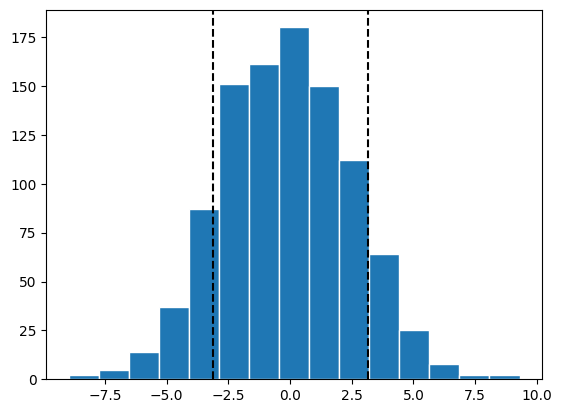

In [ ]:
plt.figure()
plt.hist(resampled_difference, bins = 15, edgecolor = "white")
plt.axvline(observed_difference, color = "black", linestyle = "--")
plt.axvline(-observed_difference, color = "black", linestyle = "--")
plt.show()

Otomatik olarak aynı işlem şu şekilde yapılabilir:

In [ ]:
results = stats.permutation_test((a,b), statistic = lambda x,y: np.mean(x) - np.mean(y),
                                 n_resamples = 1000,vectorized=False)
results.pvalue

0.1998001998001998

## 2.SORU

* $H_0: \mu_1 - \mu_2 = 0$
* $H_A: \mu_1 - \mu_2 \neq 0$

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/stem_cell.csv")
df.head()

,trmt,before,after
0,ctrl,35.25,29.50
1,ctrl,36.50,29.50
2,ctrl,39.75,36.25
3,ctrl,39.75,38.00
4,ctrl,41.75,37.50


In [ ]:
df = df.assign(Diff = lambda x: x.after - x["before"])
control = df[df.trmt == "ctrl"].Diff.values
treatment = df[df.trmt == "esc"].Diff.values

In [ ]:
observed_difference = np.mean(control) - np.mean(treatment)
observed_difference

-7.833333333333333

In [ ]:
combined_data = np.concatenate((control,treatment))
resampled_differences = []
p_value = 0
for _ in range(10000):
  np.random.shuffle(combined_data)
  resampled_control = combined_data[:len(control)]
  resampled_treatment = combined_data[len(control):]

  resampled_difference = np.mean(resampled_control) - np.mean(resampled_treatment)
  resampled_differences.append(resampled_difference)
  if np.abs(resampled_difference) >= np.abs(observed_difference):
    p_value += 1

resampled_differences = np.array(resampled_differences)
p_value = p_value / 10000
p_value

0.0001

In [ ]:
results = stats.permutation_test((control,treatment), statistic = lambda x,y: np.mean(x) - np.mean(y), n_resamples = 10000,
                       vectorized = False)
results.statistic,results.pvalue

(-7.833333333333333, 0.0011998800119988001)

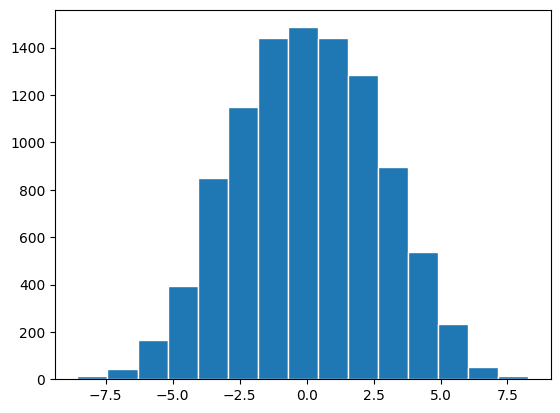

In [ ]:
plt.figure()
plt.hist(results.null_distribution, bins = 15, edgecolor = "white")
plt.show()

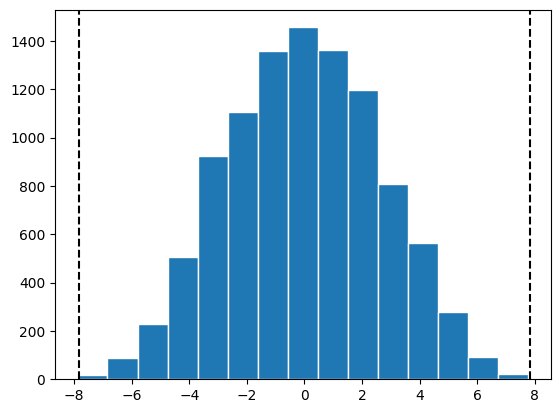

In [ ]:
plt.figure()
plt.hist(resampled_differences, bins = 15, edgecolor = "white")
plt.axvline(observed_difference, color = "black", linestyle = "--")
plt.axvline(-observed_difference, color = "black", linestyle = "--")
plt.show()

## 3.SORU

* $H_0: \mu_1 - \mu_2 = 0$
* $H_A: \mu_1 - \mu_2 \neq 0$


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/births14.csv")
df.head()

,fage,mage,mature,weeks,premie,visits,gained,weight,lowbirthweight,sex,habit,marital,whitemom
0,34.0,34,younger mom,37,full term,14.0,28.0,6.96,not low,male,nonsmoker,married,white
1,36.0,31,younger mom,41,full term,12.0,41.0,8.86,not low,female,nonsmoker,married,white
2,37.0,36,mature mom,37,full term,10.0,28.0,7.51,not low,female,nonsmoker,married,not white
3,NaN,16,younger mom,38,full term,NaN,29.0,6.19,not low,male,nonsmoker,not married,white
4,32.0,31,younger mom,36,premie,12.0,48.0,6.75,not low,female,nonsmoker,married,white


In [ ]:
smoker = df[df.habit == "smoker"].weight.values
nonsmoker = df[df.habit == "nonsmoker"].weight.values

observed_difference = np.mean(smoker) - np.mean(nonsmoker)

In [ ]:
resampled_differences = []
p_value = 0

for _ in range(10000):
  combined_data = np.concatenate((smoker,nonsmoker))
  np.random.shuffle(combined_data)
  resampled_smoker = combined_data[:len(smoker)]
  resampled_nonsmoker = combined_data[len(smoker):]
  resampled_difference = np.mean(resampled_smoker) - np.mean(resampled_nonsmoker)
  resampled_differences.append(resampled_difference)
  if np.abs(resampled_difference) >= np.abs(observed_difference):
    p_value += 1

p_value = p_value / 10000
p_value

0.0

In [ ]:
resampled_differences = np.array(resampled_differences)
results = stats.permutation_test((smoker,nonsmoker), statistic = lambda x,y: np.mean(x) - np.mean(y), n_resamples = 10000,
                       vectorized = False)
results.statistic,results.pvalue

(-0.5926801432647366, 0.00019998000199980003)

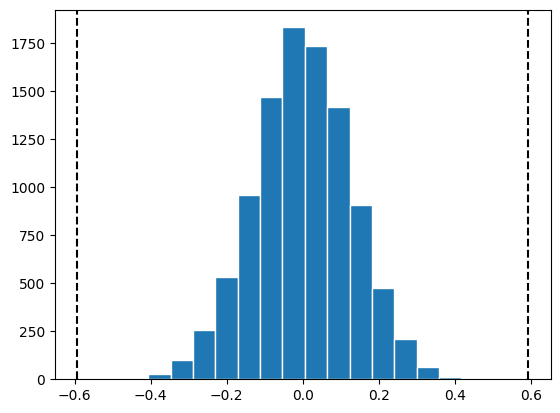

In [ ]:
plt.figure()
plt.hist(resampled_differences, bins = 15, edgecolor = "white")
plt.axvline(observed_difference, color = "black", linestyle = "--")
plt.axvline(-observed_difference, color = "black", linestyle = "--")
plt.show()

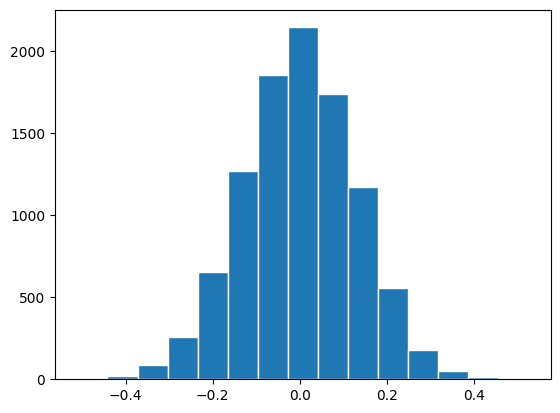

In [ ]:
plt.figure()
plt.hist(results.null_distribution, bins = 15, edgecolor = "white")
plt.show()

### T-testi

**T-testi Varsayımlar**

* Örnekler birbirlerinden bağımsızlardır.
* Her gruba ait en az 30 örnek vardır.
* Ekstrem outlier hiçbir grupta yoktur.

Aşırı çarpık dağılımlar olmadığı ve dağılımlar simetrikimsi olduğu sürece t-testini kullanabilirsin. Bimodal olmasın yeter.

* Asla t-testini ordinal (sıralı kategorik) ve nominal (sırasız kategorik) değişkenleri kıyaslamak için kullanma.

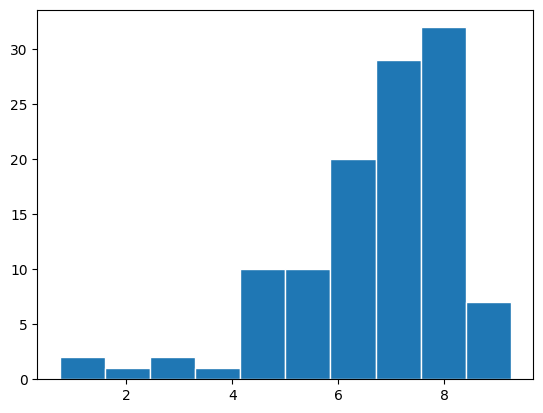

In [ ]:
plt.hist(smoker, bins = 10, edgecolor = "white")
plt.show()

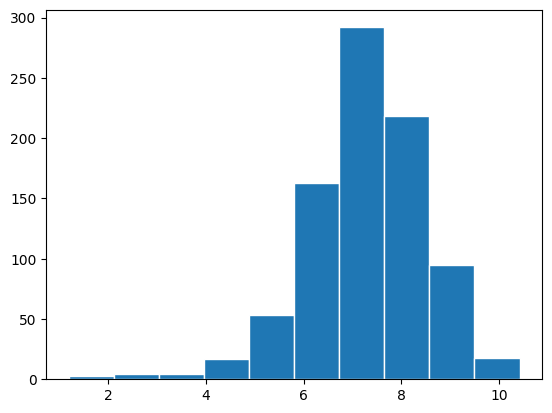

In [ ]:
plt.hist(nonsmoker, bins = 10, edgecolor = "white")
plt.show()

In [ ]:
stats.ttest_ind(smoker,nonsmoker)

TtestResult(statistic=-4.64724060877841, pvalue=3.823833718442317e-06, df=979.0)

In [ ]:
pg.ttest(smoker,nonsmoker,alternative = "two-sided")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.816591,131.306366,two-sided,0.000208,"[-0.9, -0.29]",0.462986,120.926,0.996349


95% eminlilikle sigara içenler ile sigara içmeyenler arasındaki fark (-0.9,-0.29) aralığındadır.

## 4.SORU

**Q:** 99 karat ve 1 karat arasındaki fiyat farkı kayda değer mi?



In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/diamonds.csv")
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
group1 = df[df.carat == 0.99].price.values
group2 = df[df.carat == 1].price.values

In [ ]:
results = stats.permutation_test((group1,group2),
                       statistic = lambda x,y: np.mean(x) - np.mean(y),
                       n_resamples = 10000,
                       vectorized = False)

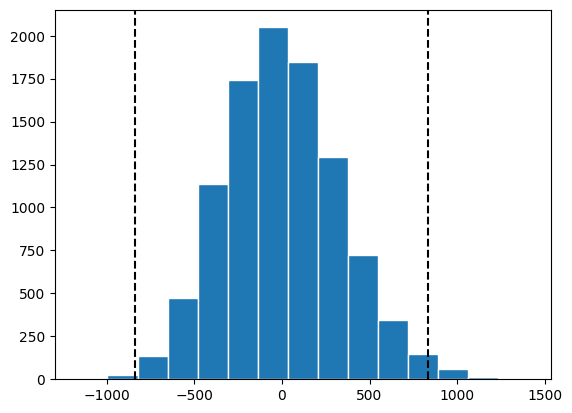

In [ ]:
observed_difference = np.mean(group1) - np.mean(group2)
plt.figure()
plt.hist(results.null_distribution, bins = 15, edgecolor = "white")
plt.axvline(observed_difference, color = "black", linestyle = "--")
plt.axvline(-observed_difference, color = "black", linestyle = "--")
plt.show()

In [ ]:
results.pvalue

0.0051994800519948

### T-testi

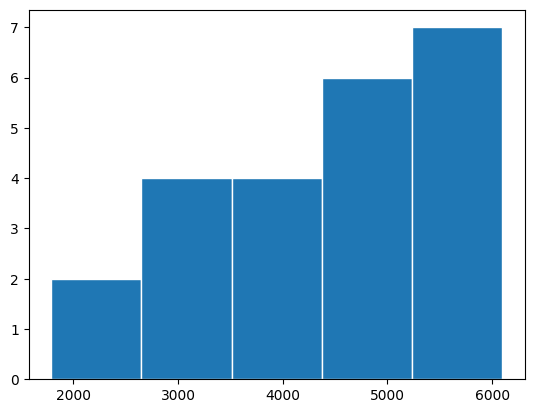

In [ ]:
plt.hist(group1, bins = 5, edgecolor = "white")
plt.show()

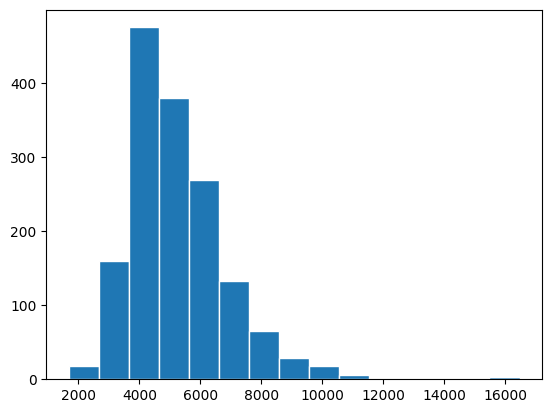

In [ ]:
plt.hist(group2, bins = 15, edgecolor = "white")
plt.show()

In [ ]:
pg.ttest(group1,group2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.004945,22.970851,two-sided,0.006322,"[-1410.57, -260.26]",0.522031,12.281,0.699803


## 5.SORU
**Q:** Horsebean vs lindseed

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/chickwts.csv")
df.head()

,Unnamed: 0,weight,feed
0,1,179,horsebean
1,2,160,horsebean
2,3,136,horsebean
3,4,227,horsebean
4,5,217,horsebean


In [ ]:
horsebean = df[df.feed == "horsebean"].weight.values
linseed = df[df.feed == "linseed"].weight.values

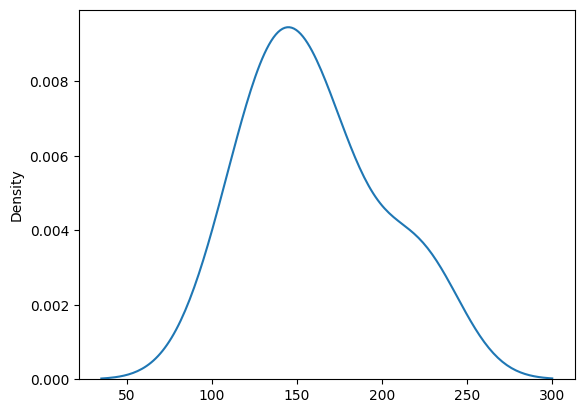

In [ ]:
sns.kdeplot(horsebean);

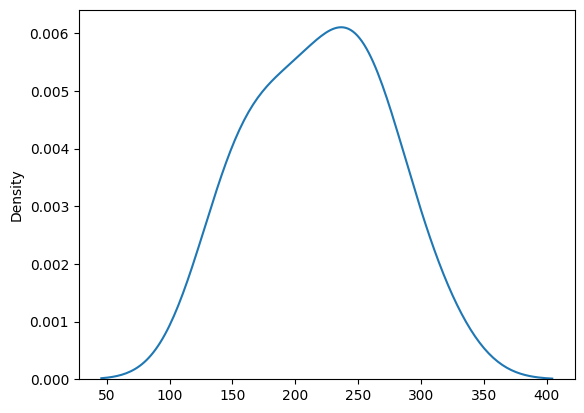

In [ ]:
sns.kdeplot(linseed);

### T-testi

In [ ]:
pg.ttest(horsebean,linseed)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.017175,19.76872,two-sided,0.006869,"[-99.06, -18.04]",1.256284,6.863,0.796952


In [ ]:
pg.ttest(horsebean,linseed,confidence = 0.99)

,T,dof,alternative,p-val,CI99%,cohen-d,BF10,power
T-test,-3.017175,19.76872,two-sided,0.006869,"[-113.83246236330969, -3.26753763669034]",1.256284,6.863,0.796952


## 6.SORU (TEST İSTATİSTİKLERİ ÜZERİNDEN)

In [ ]:
stats.ttest_ind_from_stats(mean1 = 23.7, std1 = 3.90,nobs1 = 25,
                           mean2 = 30.9, std2 = 5.13, nobs2 = 25)

Ttest_indResult(statistic=-5.58647352251128, pvalue=1.0667294937703327e-06)

# Eşli Gruplar Üzerinden Çıkarımlar

Eşli grupların birbirlerinden farklı olup olmadıklarını aralarındaki farkı hesaplayarak ve bu farkı modelleyerek analiz ederiz.

# SORULAR

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/ucla_textbooks_f18.csv")
df = df[["bookstore_new","amazon_new"]].dropna().reset_index(drop = True)
df.head()

,bookstore_new,amazon_new
0,47.97,47.45
1,14.26,13.55
2,13.50,12.53
3,49.26,54.95
4,119.97,124.80


In [ ]:
df = df.assign(diff = lambda x: x.bookstore_new - x.amazon_new)
simulations = stats.bootstrap((df["diff"].values,),
                              statistic = np.mean,
                              )

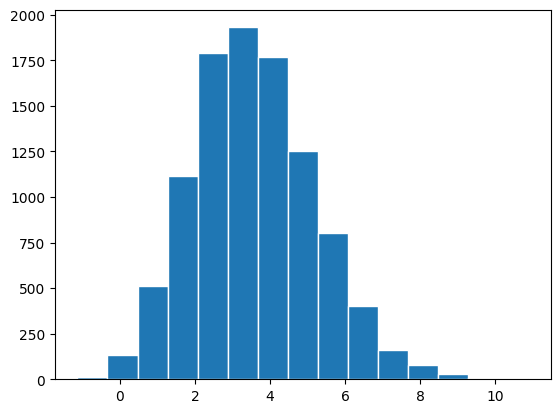

In [ ]:
plt.figure()
plt.hist(simulations.bootstrap_distribution, bins = 15, edgecolor = "white")
plt.show()

Alternatif olarak:

In [ ]:
simulations = stats.bootstrap((df["bookstore_new"],df["amazon_new"]),
                              statistic = lambda x,y: np.mean(x) - np.mean(y),
                              paired = True)

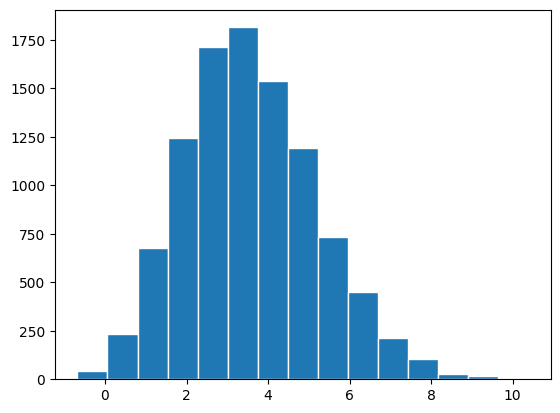

In [ ]:
plt.figure()
plt.hist(simulations.bootstrap_distribution, bins = 15, edgecolor = "white")
plt.show()

### Standart Hata ve Persentil Aralıkları

Persentil aralıkları asimetrik bootstrap dağılımında, standart hata aralıkları daha simetrik bootstrap dağılımlarında kullanılmalıdır.

In [ ]:
percentile_interval = (np.percentile(simulations.bootstrap_distribution,2.5),
                       np.percentile(simulations.bootstrap_distribution,97.5))
percentile_interval

(0.7026911764705888, 6.991625000000001)

In [ ]:
standard_error_interval = (np.mean(simulations.bootstrap_distribution) - 1.96 * np.std(simulations.bootstrap_distribution),
                           np.mean(simulations.bootstrap_distribution) + 1.96 * np.std(simulations.bootstrap_distribution))
standard_error_interval


(0.39411883451105245, 6.741534201380773)

### T-testi

$T = \frac {\mu_{diff}-0} {s_{diff}/\sqrt{n}}$

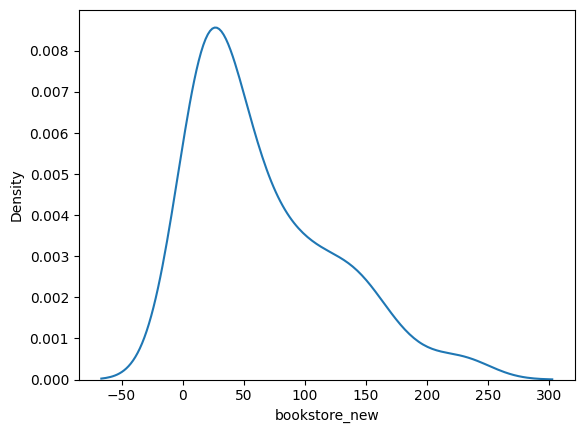

In [ ]:
sns.kdeplot(df["bookstore_new"]);

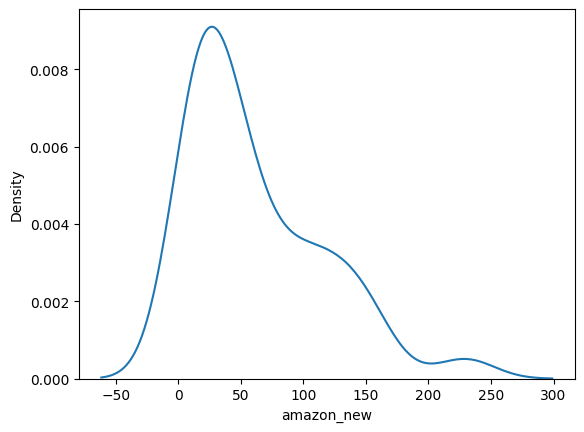

In [ ]:
sns.kdeplot(df["amazon_new"]);

In [ ]:
stats.ttest_rel(df["bookstore_new"],df["amazon_new"])

TtestResult(statistic=2.2012283321425237, pvalue=0.031168934694962843, df=67)

In [ ]:
pg.ttest(df["bookstore_new"],df["amazon_new"],paired = True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.201228,67,two-sided,0.031169,"[0.33, 6.83]",0.064558,1.268,0.082097


95% eminlilikle ilk grup ikincisinden [0.33, 6.83] aralığında farklı fiyata sahiptir.

# İkiden Fazla Popülasyon Üzerinden Çıkarımlar

**ANOVA**

* Grupları ikişerli olarak t-testine sokmak Tip-1 hata oranını artırdığından doğru bir yaklaşım değildir.

* Bunun yerine ANOVA testini kullanırız. Hipotezler:

$H_0: \mu_1 = \mu_2 = ...=\mu_n$

$H_A: $At least one is different.

**Varsayımlar:**

1. Her grup normalimsidir. (Simetrik gibi ve aşırı uç değerlere sahip değil)
2. Tüm örnekler bağımsızdır.
3. Varyanslar gruplar arasında benzerdir.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/mlb_players_18.csv")
df.head()

,name,team,position,games,AB,R,H,doubles,triples,HR,RBI,walks,strike_outs,stolen_bases,caught_stealing_base,AVG,OBP,SLG,OPS
0,"Allard, K",ATL,P,3,1,1,1,0,0,0,0,0,0,0,0,1.0,1.0,1.0,2.0
1,"Gibson, K",MIN,P,1,2,2,2,0,0,0,0,0,0,0,0,1.0,1.0,1.0,2.0
2,"Law, D",SF,P,7,1,1,1,0,0,0,0,0,0,0,0,1.0,1.0,1.0,2.0
3,"Nuno, V",TB,P,1,2,0,2,0,0,0,1,0,0,0,0,1.0,1.0,1.0,2.0
4,"Romero, E",KC,P,4,1,1,1,1,0,0,0,0,0,0,0,1.0,1.0,2.0,3.0


In [ ]:
df.position.value_counts()

,count
position,
P,642
C,115
2B,83
CF,79
RF,76
3B,73
LF,70
SS,67
1B,59


In [ ]:
group1 = df[df.position == "CF"].OBP.values
group2 = df[df.position == "2B"].OBP.values
group3 = df[df.position == "C"].OBP.values
stats.f_oneway(group1,group2,group3)

F_onewayResult(statistic=0.12184677828838893, pvalue=0.8853319446600435)

In [ ]:
stats.f_oneway(group1,group2,group3)

F_onewayResult(statistic=0.12184677828838893, pvalue=0.8853319446600435)

In [ ]:
group1.mean(),group2.mean(),group3.mean()

(0.28868354430379745, 0.2848795180722892, 0.283304347826087)

## Permutation Test

**Kitap Açıklaması**

The larger the observed variability in the sample means (𝑀𝑆𝐺) relative to the within-group observations
(𝑀𝑆𝐸), the larger 𝐹 -statistic will be and the stronger the evidence against the null hypothesis.
Because larger 𝐹 -statistics represent stronger evidence against the null hypothesis, we use the upper
tail of the distribution to compute a p-value.

In [ ]:
observed_fstat = stats.f_oneway(group1, group2, group3).statistic
combined_data = np.concatenate((group1, group2, group3))
p_value = 0
resampled_fstats = []

for _ in range(10000):
    np.random.shuffle(combined_data)
    resampled_group1 = combined_data[:len(group1)]
    resampled_group2 = combined_data[len(group1):len(group1) + len(group2)]
    resampled_group3 = combined_data[len(group1) + len(group2):]

    resampled_fstat = stats.f_oneway(resampled_group1, resampled_group2, resampled_group3).statistic
    if resampled_fstat >= observed_fstat:
        p_value += 1
    resampled_fstats.append(resampled_fstat)

p_value = p_value / 10000
resampled_fstats = np.array(resampled_fstats)

print("Gözlemlenen F istatistiği:", observed_fstat)
print("p-değeri:", p_value)

Gözlemlenen F istatistiği: 0.12184677828838893
p-değeri: 0.8836


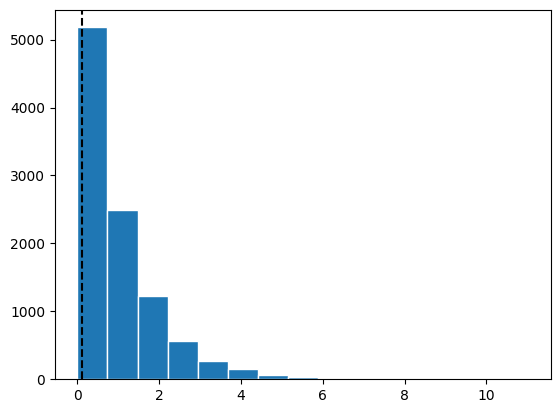

In [ ]:
plt.figure()
plt.hist(resampled_fstats, bins = 15, edgecolor = "white")
plt.axvline(observed_fstat, color = "black", linestyle = "--")
plt.show()

Otomatik olarak şu şekilde gerçekleştiririz. Yalnız yanlış sonuç verebilir. Manuel olarak hesaplamakta fayda var. [Link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.permutation_test.html#:~:text=The%20p%2Dvalue%20is%20calculated%20by,p%2Dvalue%20manually.%20See%20example%20below.)

In [ ]:
results = stats.permutation_test((group1,group2,group3),
                       statistic = lambda x,y,z: stats.f_oneway(x,y,z).statistic,
                       n_resamples = 10000,
                       vectorized = False)
results.statistic,results.pvalue

(0.12184677828838893, 0.22417758224177584)

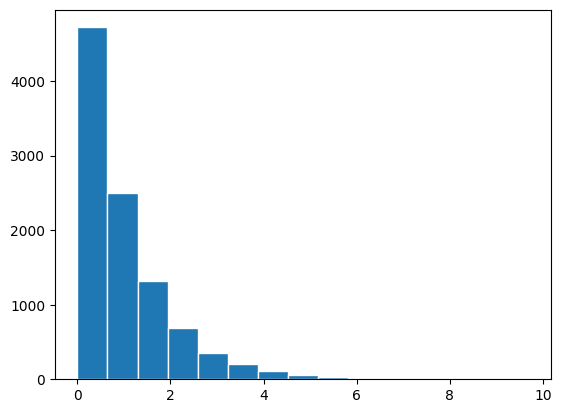

In [ ]:
plt.figure()
plt.hist(results.null_distribution, bins = 15, edgecolor = "white")
plt.show()

## ANOVA

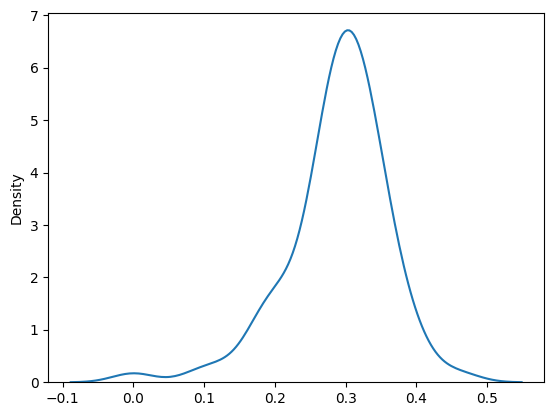

In [ ]:
sns.kdeplot(group1);

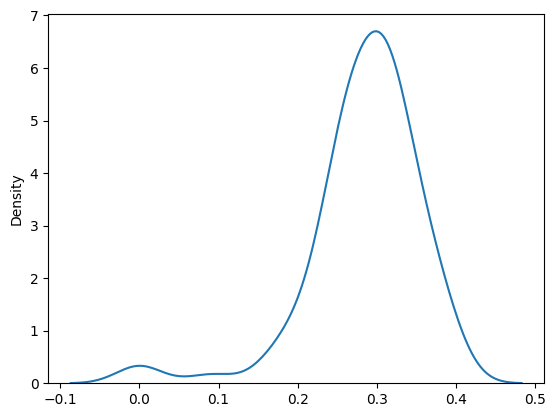

In [ ]:
sns.kdeplot(group2);

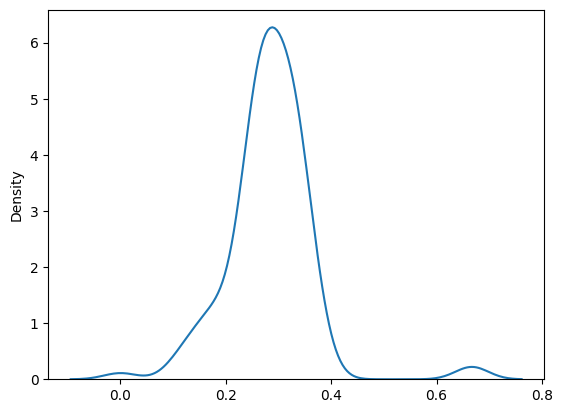

In [ ]:
sns.kdeplot(group3);

Gruplar normalimsi. Aşırı uç veriler yok.

In [ ]:
stats.f_oneway(group1,group2,group3)

F_onewayResult(statistic=0.12184677828838893, pvalue=0.8853319446600435)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/chickwts.csv")
df.head()

,Unnamed: 0,weight,feed
0,1,179,horsebean
1,2,160,horsebean
2,3,136,horsebean
3,4,227,horsebean
4,5,217,horsebean


In [ ]:
df.feed.value_counts()

,count
feed,
soybean,14
linseed,12
sunflower,12
casein,12
meatmeal,11
horsebean,10


<Axes: xlabel='feed', ylabel='weight'>

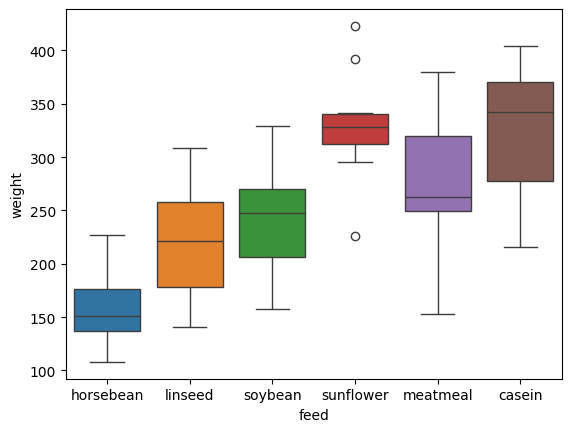

In [ ]:
sns.boxplot(x="feed", y="weight", hue="feed", data=df)


In [ ]:
groups = [group["weight"].values for _,group in df.groupby("feed")]
stats.f_oneway(*groups)

F_onewayResult(statistic=15.364799774712534, pvalue=5.936419853471331e-10)

# Bivariate Regresyon Üzerinden Çıkarımlar

**Uyarı:** İstatistiki paketler hesaplamaları otomatik olarak yaparlar ancak hipotez testleri ve regresyon varsayımlarının karşılanıp karşılanmadığını kontrol etmezler. Önceden senin bunları kontrol etmen gerekir.

* Bağımsız örnekler
* Normal dağılan residue
* Lineer veri dağılımı

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/midterms_house.csv")
df.head()

,year,potus,party,unemp,house_change
0,1899,William McKinley,Republican,11.62,-9.223301
1,1903,Theodore Roosevelt,Republican,4.30,-4.275907
2,1907,Theodore Roosevelt,Republican,3.29,-12.291499
3,1911,William Howard Taft,Republican,5.86,-26.590640
4,1915,Woodrow Wilson,Democrat,6.63,-20.962199


In [ ]:
y = df.house_change.values
X = sm.add_constant(df.unemp.values)
model = sm.OLS(y,X)
result = model.fit()

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                   0.01400
Date:                Mon, 14 Oct 2024   Prob (F-statistic):              0.907
Time:                        11:07:34   Log-Likelihood:                -112.35
No. Observations:                  31   AIC:                             228.7
Df Residuals:                      29   BIC:                             231.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7028      3.361     -3.779      0.001     -19.577      -5.829
x1             0.0511      0.432      0.118      0.907      -0.833       0.935
==============================================================================
Omnibus:                        5.609   Durbin-Watson:                   2.519
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                1.862
Skew:                           0.042   Prob(JB):                        0.394
Kurtosis:                       1.802   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regresyon eğim katsayısı önemli değil.

In [ ]:
result.conf_int(alpha = 0.05)

array([[-19.57685118,  -5.82883273],
       [ -0.83251979,   0.93476707]])

In [ ]:
result.params

array([-12.70284196,   0.05112364])

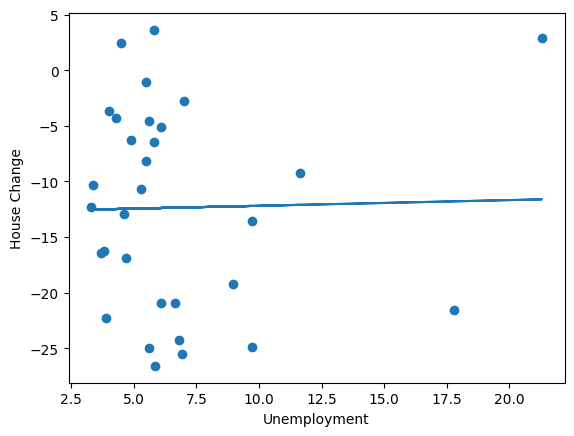

In [ ]:
plt.figure()
plt.scatter(df.unemp,df.house_change)
plt.plot(df.unemp,result.predict(X))
plt.xlabel("Unemployment")
plt.ylabel("House Change")
plt.show()

## 2.SORU

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/elmhurst.csv")
df.head()

,family_income,gift_aid,price_paid
0,92.922,21.72,14.28
1,0.250,27.47,8.53
2,53.092,27.75,14.25
3,50.200,27.22,8.78
4,137.613,18.00,24.00


### Varsayımların Kontrolü

<Axes: xlabel='gift_aid', ylabel='Density'>

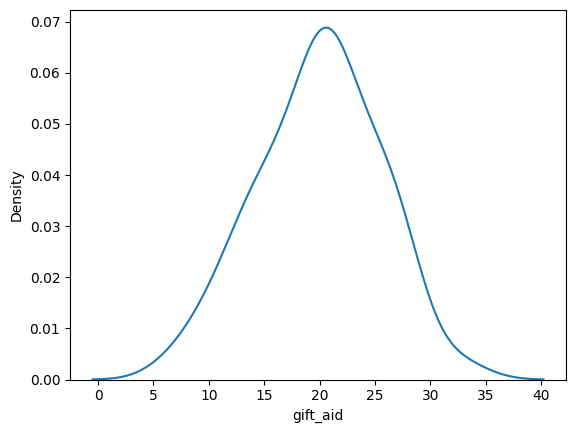

In [ ]:
sns.kdeplot(df.gift_aid)

<Axes: xlabel='family_income', ylabel='Density'>

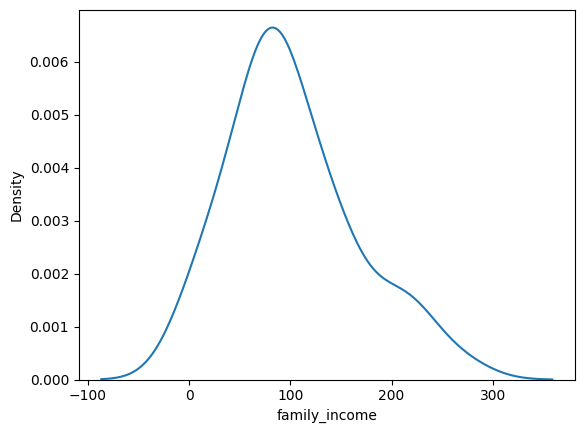

In [ ]:
sns.kdeplot(df.family_income)

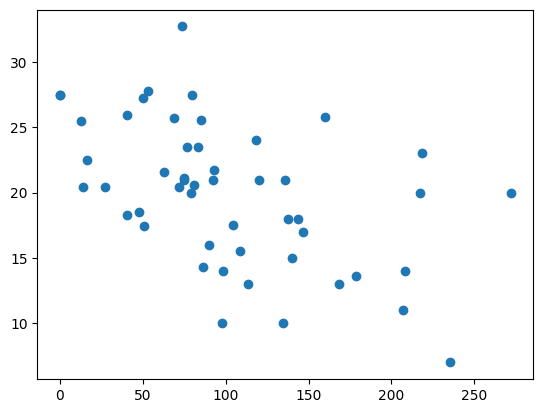

In [ ]:
plt.scatter(df.family_income,df.gift_aid)

### Model Oluşturma ve Sonuçlar

In [ ]:
X = sm.add_constant(df.family_income.values)
y = df.gift_aid.values
model = sm.OLS(y,X)
result = model.fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.233   
Dependent Variable: y                AIC:                300.3512
Date:               2024-10-14 11:16 BIC:                304.1752
No. Observations:   50               Log-Likelihood:     -148.18 
Df Model:           1                F-statistic:        15.88   
Df Residuals:       48               Prob (F-statistic): 0.000229
R-squared:          0.249            Scale:              22.873  
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const     24.3193     1.2915   18.8310   0.0000   21.7227   26.9160
x1        -0.0431     0.0108   -3.9846   0.0002   -0.0648   -0.0213
-----------------------------------------------------------------
Omnibus:              0.440        Durbin-Watson:           1.386
Prob(Omnibus):        0.802        Jarque-Bera (JB):        0.596
Skew:                 0.163        Prob(JB):                0.742
Kurtosis:             2.576        Condition No.:           228  
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [ ]:
preds_summary = preds.summary_frame()
preds_summary.head(3)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,20.317025,0.683103,18.943554,21.690496,10.603373,30.030676
1,24.308561,1.289149,21.716553,26.900569,14.349289,34.267833
2,22.032569,0.856990,20.309476,23.755662,12.263349,31.801788


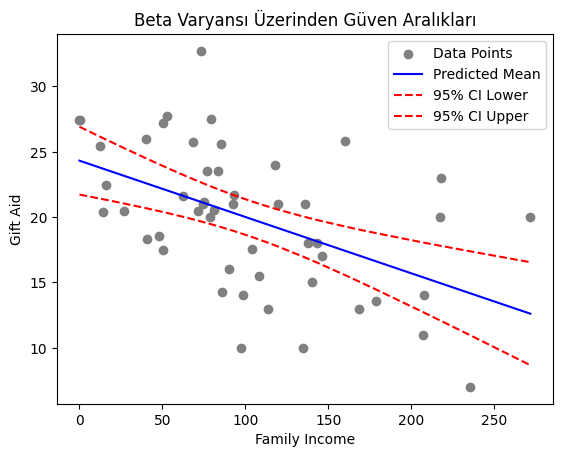

In [ ]:
# Family Income değerine göre sıralama
sorted_indices = df.family_income.argsort()
sorted_income = df.family_income.iloc[sorted_indices]
sorted_gift_aid = preds_summary.iloc[sorted_indices]

# Grafik çizimi
plt.figure()
plt.scatter(df.family_income, df.gift_aid, color='grey', label='Data Points')
plt.plot(sorted_income, sorted_gift_aid["mean"], color='blue', label='Predicted Mean')
plt.plot(sorted_income, sorted_gift_aid["mean_ci_lower"], color='red', linestyle='--', label='95% CI Lower')
plt.plot(sorted_income, sorted_gift_aid["mean_ci_upper"], color='red', linestyle='--', label='95% CI Upper')
plt.xlabel("Family Income")
plt.ylabel("Gift Aid")
plt.title("Beta Varyansı Üzerinden Güven Aralıkları")
plt.legend()
plt.show()

Beta varyansları OLS'nin analitik çözümüyle hesaplanır.

$Var(β)=σ^2(X^TX)^{−1}$

Alternatif olarak bootstraple tekrar tekrar örneklenip her noktadaki sapmayla da hesaplanabilir.

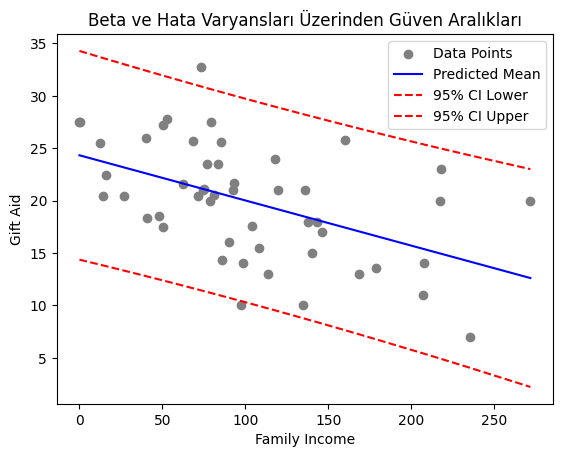

In [ ]:
# Family Income değerine göre sıralama
sorted_indices = df.family_income.argsort()
sorted_income = df.family_income.iloc[sorted_indices]
sorted_gift_aid = preds_summary.iloc[sorted_indices]

# Grafik çizimi
plt.figure()
plt.scatter(df.family_income, df.gift_aid, color='grey', label='Data Points')
plt.plot(sorted_income, sorted_gift_aid["mean"], color='blue', label='Predicted Mean')
plt.plot(sorted_income, sorted_gift_aid["obs_ci_lower"], color='red', linestyle='--', label='95% CI Lower')
plt.plot(sorted_income, sorted_gift_aid["obs_ci_upper"], color='red', linestyle='--', label='95% CI Upper')
plt.xlabel("Family Income")
plt.ylabel("Gift Aid")
plt.title("Beta ve Hata Varyansları Üzerinden Güven Aralıkları")
plt.legend()
plt.show()

OLS analitik çözümü

$\hat{y} \pm t_{α/2,n-k} · \sqrt{\sigma^2 + \sigma_{hat}^2}$

## 3.SORU

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/bac.csv")
df.head()

,student,beers,bac
0,1,5,0.10
1,2,2,0.03
2,3,9,0.19
3,4,8,0.12
4,5,3,0.04


### Varsayımların Kontrolü

<Axes: xlabel='beers', ylabel='Density'>

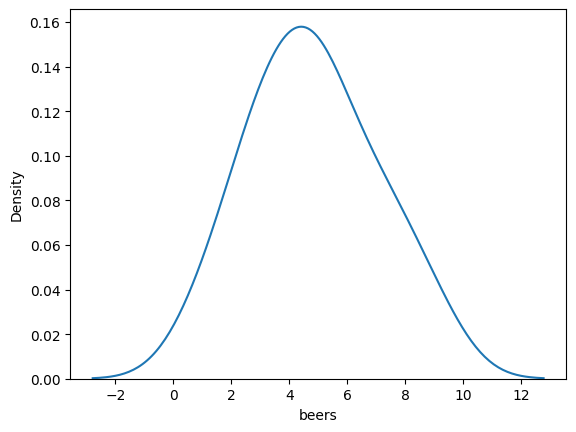

In [ ]:
sns.kdeplot(df.beers)

<Axes: xlabel='bac', ylabel='Density'>

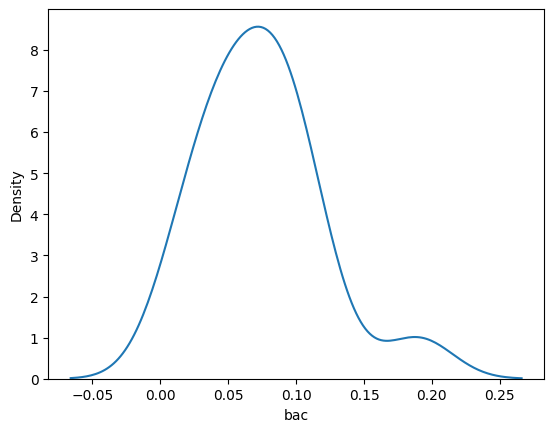

In [ ]:
sns.kdeplot(df.bac)

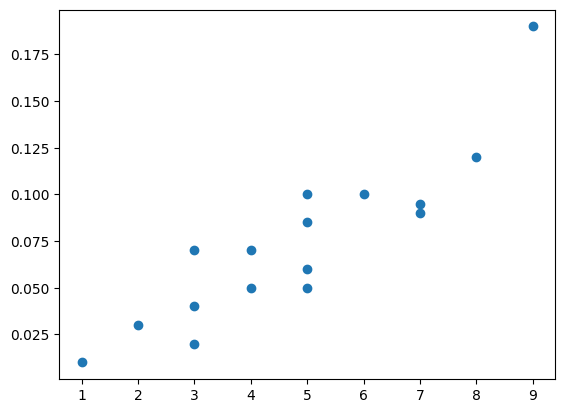

In [ ]:
plt.scatter(df.beers,df.bac);

In [ ]:
y = df.bac.values
X = sm.add_constant(df.beers.values)
model = sm.OLS(y,X)
result = model.fit()
result.summary2()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.786     
Dependent Variable: y                AIC:                -77.2173  
Date:               2024-10-14 11:53 BIC:                -75.6722  
No. Observations:   16               Log-Likelihood:     40.609    
Df Model:           1                F-statistic:        55.94     
Df Residuals:       14               Prob (F-statistic): 2.97e-06  
R-squared:          0.800            Scale:              0.00041783
----------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
----------------------------------------------------------------------
const    -0.0127      0.0126    -1.0050    0.3320    -0.0398    0.0144
x1        0.0180      0.0024     7.4796    0.0000     0.0128    0.0231
-------------------------------------------------------------------
Omnibus:                0.963        Durbin-Watson:           2.100
Prob(Omnibus):          0.618        Jarque-Bera (JB):        0.859
Skew:                   0.470        Prob(JB):                0.651
Kurtosis:               2.364        Condition No.:           13   
===================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

Regression line:

$\hat{y} = -0.01 + 0.018x$

Katsayı önemsizdir. Eğim önemlidir.

İlişki Yorumu

Biça içişindeki 1 birimlik artış BAC değerlendirmesinde 0.018'lik bir artışa sebep olmaktadır.

In [ ]:
model = pg.linear_regression(df.beers,df.bac)
model

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.012701,0.012638,-1.004993,0.331955,0.799841,0.785544,-0.039805,0.014404
1,beers,0.017964,0.002402,7.479592,0.000003,0.799841,0.785544,0.012813,0.023115


### Permütasyon Testiyle Regresyon

Bu metod çok küçük veri setlerinde varsayımlar sağlanamadığında kullanılır.

ÇOK GÜVENİLİR DEĞİL

In [ ]:
model = sm.OLS(y,X).fit()
observed_t = model.tvalues
resampled_results = []
for _ in range(50000):
    np.random.shuffle(y)
    resampled_model = sm.OLS(y,X).fit()
    resampled_t = resampled_model.tvalues
    resampled_results.append(resampled_t)

resampled_results = np.array(resampled_results)
p_values = np.mean(np.abs(resampled_results) >= np.abs(observed_t), axis=0)
for i, coef in enumerate(model.params):
    print(f"Katsayı {i} - Gerçek t: {observed_t[i]:.4f}, p-değeri: {p_values[i]:.4f}")

Katsayı 0 - Gerçek t: 1.5253, p-değeri: 0.9024
Katsayı 1 - Gerçek t: 1.3731, p-değeri: 0.1914


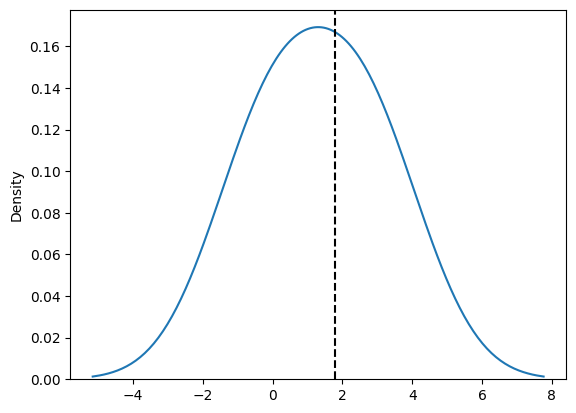

In [ ]:
plt.figure()
sns.kdeplot(resampled_results[0])
plt.axvline(observed_t[0], color = "black", linestyle = "--")
plt.show()

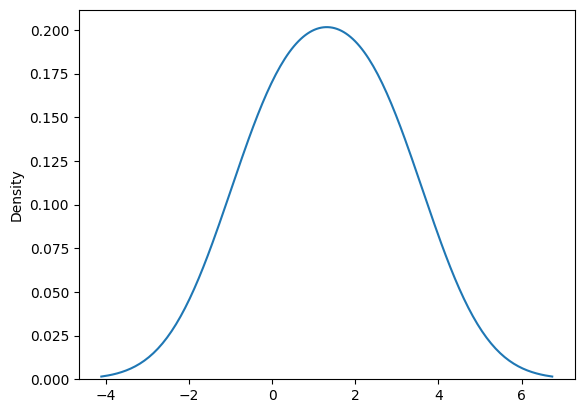

In [ ]:
sns.kdeplot(resampled_results[1]);

# Multivariate Regresyon Üzerinden Çıkarımlar

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/loans_full_schema.csv")
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [ ]:
df = df.dropna()
y = df.interest_rate
X = sm.add_constant(df[["debt_to_income","term"]])
model = sm.OLS(y,X).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.088    
Dependent Variable: interest_rate    AIC:                1242.9657
Date:               2024-10-14 12:20 BIC:                1252.8757
No. Observations:   201              Log-Likelihood:     -618.48  
Df Model:           2                F-statistic:        10.63    
Df Residuals:       198              Prob (F-statistic): 4.14e-05 
R-squared:          0.097            Scale:              27.972   
-------------------------------------------------------------------
                 Coef.   Std.Err.    t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const            7.9181    1.5793  5.0138  0.0000   4.8038  11.0325
debt_to_income   0.0083    0.0097  0.8514  0.3956  -0.0109   0.0275
term             0.1453    0.0316  4.6010  0.0000   0.0830   0.2075
------------------------------------------------------------------
Omnibus:               13.855       Durbin-Watson:          2.069 
Prob(Omnibus):         0.001        Jarque-Bera (JB):       14.461
Skew:                  0.621        Prob(JB):               0.001 
Kurtosis:              2.569        Condition No.:          260   
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

## Multikolineerite

Predictorlar arasında bir ilişki bulunduğunda regresyon katsayıları çıkarımsal özelliklerini kaybederler. Öte yandan, amacımız sadece öngörü yapmak ise multikolineerite bir problem yaratmaz.



# SORULAR

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/penguins.csv").dropna().reset_index(drop = True)
df.head()

,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
4,6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [ ]:
y1 = df.body_mass_g.values
X1 = sm.add_constant(df.bill_length_mm.values)
y2 = df.body_mass_g.values
X2 = sm.add_constant(df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]])

In [ ]:
model1 = sm.OLS(y1,X1).fit()
model1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.345     
Dependent Variable: y                AIC:                5262.1428 
Date:               2024-10-14 13:41 BIC:                5269.7591 
No. Observations:   333              Log-Likelihood:     -2629.1   
Df Model:           1                F-statistic:        176.2     
Df Residuals:       331              Prob (F-statistic): 1.54e-32  
R-squared:          0.347            Scale:              4.2437e+05
---------------------------------------------------------------------
         Coef.     Std.Err.      t      P>|t|      [0.025     0.975] 
---------------------------------------------------------------------
const   388.8452   289.8172    1.3417   0.1806   -181.2707   958.9610
x1       86.7918     6.5377   13.2756   0.0000     73.9311    99.6524
-------------------------------------------------------------------
Omnibus:               6.141         Durbin-Watson:           0.849
Prob(Omnibus):         0.046         Jarque-Bera (JB):        4.899
Skew:                  -0.197        Prob(JB):                0.086
Kurtosis:              2.555         Condition No.:           360  
===================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

In [ ]:
model2 = sm.OLS(y2,X2).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Ordinary least squares
===========================================================================
Model:                  OLS                Adj. R-squared:       0.762     
Dependent Variable:     y                  AIC:                  4927.5539 
Date:                   2024-10-14 13:41   BIC:                  4942.7864 
No. Observations:       333                Log-Likelihood:       -2459.8   
Df Model:               3                  F-statistic:          354.9     
Df Residuals:           329                Prob (F-statistic):   9.26e-103 
R-squared:              0.764              Scale:                1.5445e+05
---------------------------------------------------------------------------
                    Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
---------------------------------------------------------------------------
const             -6445.4760 566.1301 -11.3852 0.0000 -7559.1675 -5331.7846
bill_length_mm        3.2929   5.3659   0.6137 0.5399    -7.2630    13.8487
bill_depth_mm        17.8364  13.8259   1.2901 0.1979    -9.3620    45.0348
flipper_length_mm    50.7621   2.4973  20.3271 0.0000    45.8495    55.6747
---------------------------------------------------------------------------
Omnibus:                  5.596           Durbin-Watson:              1.982
Prob(Omnibus):            0.061           Jarque-Bera (JB):           5.469
Skew:                     0.312           Prob(JB):                   0.065
Kurtosis:                 3.068           Condition No.:              5441 
===========================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
[2] The condition number is large, 5.44e+03. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

Hangi model daha iyi?

## Cross Validasyon

In [ ]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

model1_errors = []
for train_index, test_index in kf.split(X1):

    trn, tst = X1[train_index], X1[test_index]
    trn_y, tst_y = y1[train_index], y1[test_index]


    model = sm.OLS(trn_y, trn).fit()
    predictions = model.predict(tst)


    mse_test = np.mean((predictions - tst_y) ** 2)
    model1_errors.append(mse_test)

model2_errors = []
for train_index, test_index in kf.split(X2):

    trn, tst = X2.iloc[train_index], X2.iloc[test_index]
    trn_y, tst_y = y2[train_index], y2[test_index]


    model = sm.OLS(trn_y, trn).fit()
    predictions = model.predict(tst)


    mse_test = np.mean((predictions - tst_y) ** 2)
    model2_errors.append(mse_test)


print("Model 1 Ortalama Test Hatası (MSE):", np.mean(model1_errors))
print("Model 2 Ortalama Test Hatası (MSE):", np.mean(model2_errors))

Model 1 Ortalama Test Hatası (MSE): 426070.4946245166
Model 2 Ortalama Test Hatası (MSE): 156061.92217748292


Model 2 daha iyi.

## 2.SORU

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Stats Data/gpa.csv")
df.head()

,gpa,studyweek,sleepnight,out,gender
0,3.89,50,6.0,3.0,female
1,3.90,15,6.0,1.0,female
2,3.75,15,7.0,1.0,female
3,3.60,10,6.0,4.0,male
4,4.00,25,7.0,3.0,female


In [ ]:
y = df.gpa.values
X = sm.add_constant(df[["studyweek","sleepnight","out"]].values)


<Axes: xlabel='gpa', ylabel='Density'>

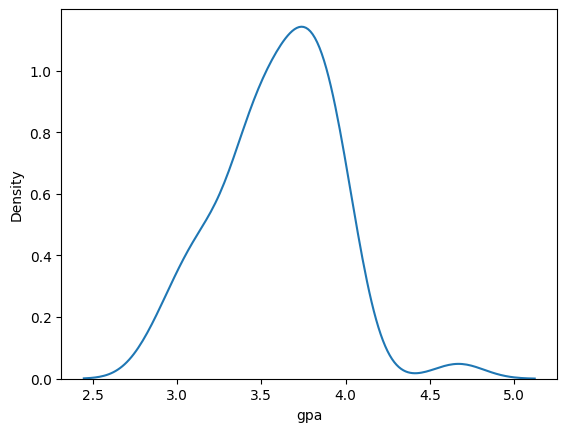

In [ ]:
sns.kdeplot(df.gpa);

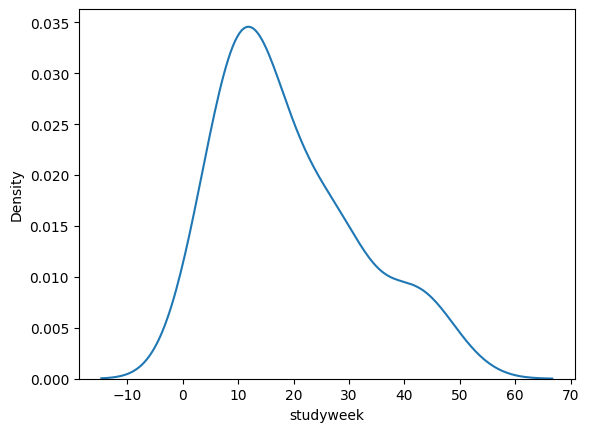

In [ ]:
sns.kdeplot(df.studyweek);

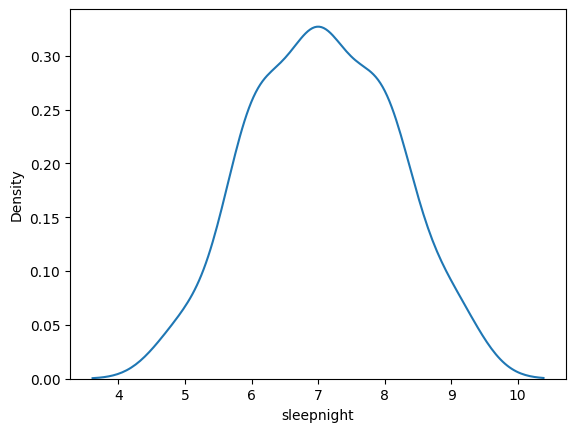

In [ ]:
sns.kdeplot(df.sleepnight);

In [ ]:
model = sm.OLS(y,X).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Ordinary least squares
================================================================
Model:              OLS              Adj. R-squared:     -0.036 
Dependent Variable: y                AIC:                41.8019
Date:               2024-10-14 13:47 BIC:                49.8313
No. Observations:   55               Log-Likelihood:     -16.901
Df Model:           3                F-statistic:        0.3675 
Df Residuals:       51               Prob (F-statistic): 0.777  
R-squared:          0.021            Scale:              0.11674
------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|     [0.025   0.975]
------------------------------------------------------------------
const       3.4348     0.3476   9.8815   0.0000    2.7370   4.1327
x1          0.0014     0.0038   0.3694   0.7133   -0.0062   0.0091
x2          0.0065     0.0494   0.1315   0.8959   -0.0928   0.1058
x3          0.0438     0.0502   0.8731   0.3867   -0.0569   0.1445
----------------------------------------------------------------
Omnibus:               1.544       Durbin-Watson:          2.456
Prob(Omnibus):         0.462       Jarque-Bera (JB):       0.799
Skew:                  0.043       Prob(JB):               0.671
Kurtosis:              3.584       Condition No.:          180  
================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

İyi bir model değil.

### Variance Influence Factor

Multikolineerite analizi için kullanılabilir. Özellikle 10'dan yüksek olan predictorlar modelden çıkarılmalıdır

In [ ]:
vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(X[:,1:], i) for i in range(X[:,1:].shape[1])]
vif_df["Features"] = "studyweek","sleepnight","out"
vif_df

,VIF,Features
0,3.049266,studyweek
1,8.557637,sleepnight
2,6.403160,out


# Logistic Regression

In [14]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score

In [11]:
X,y = make_classification(n_features = 3,n_informative = 3,n_redundant = 0)

In [13]:
model = sm.Logit(y,X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.265193
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Tue, 15 Oct 2024   Pseudo R-squ.:                  0.6174
Time:                        03:27:51   Log-Likelihood:                -26.519
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 2.595e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.6631      0.509     -5.231      0.000      -3.661      -1.665
x2            -1.2562      0.457     -2.749      0.006      -2.152      -0.361
x3            -0.6221      0.303     -2.055      0.040      -1.215      -0.029
==============================================================================
"""

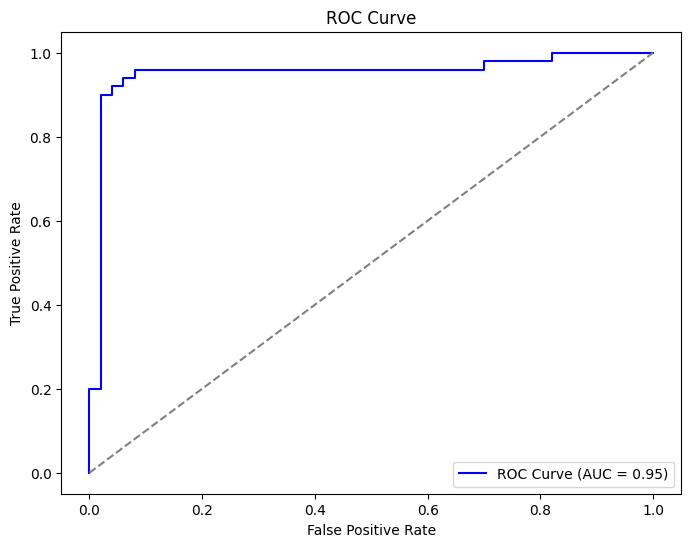

AUC Skoru: 0.9520000000000001


In [15]:
predictions = model.predict(X)
fpr,tpr,thresholds = roc_curve(y,predictions)
auc_score = roc_auc_score(y,predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diyagonal çizgi
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC Skoru:", auc_score)